<a href="https://colab.research.google.com/github/haturusinghe/cnn-gender-inceptionV3/blob/master/gender_class_model(UTK_Crop).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


# Extract Files

In [ ]:
!tar -xzvf "/content/drive/MyDrive/part1.tar.gz" -C "/content/drive/MyDrive/datasets/utk_w/"

In [ ]:
!tar -xzvf "/content/drive/MyDrive/part2.tar.gz" -C "/content/drive/MyDrive/datasets/utk_w/"

In [ ]:
!tar -xzvf "/content/drive/MyDrive/part3.tar.gz" -C "/content/drive/MyDrive/datasets/utk_w/"

In [ ]:
!tar -xzvf "/content/drive/MyDrive/crop.tar.gz" -C "/content/drive/MyDrive/datasets/"

# Files Counts

In [ ]:
!ls /content/drive/MyDrive/datasets/utk_w/part1/ -1 | wc -l

10137


In [ ]:
!ls /content/drive/MyDrive/datasets/utk_w/part2/ -1 | wc -l

10719


In [ ]:
!ls /content/drive/MyDrive/datasets/utk_w/part3/ -1 | wc -l

In [ ]:
!ls /content/drive/MyDrive/datasets/UTKFace/ -1 | wc -l

^C


# Initial Imports

In [ ]:
#Initial Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime

# To download checkpoints, Keras models, TFLite models
from google.colab import files

# Make Dataset

In [ ]:
# Fraction of the dataset to be used for testing.
TRAIN_TEST_SPLIT = 0.3

# Image size for our model.
MODEL_INPUT_IMAGE_SIZE = [ 200 , 200 ]

# Number of samples to take from dataset
N = 20000

# Trick to one-hot encode the label.
#y1 = tf.constant( [ 1. , 0. ] , dtype='float32' ) 
#y2 = tf.constant( [ 0. , 1. ] , dtype='float32' ) #Use CategoricalCrossEntropy if using one-hot

## Using inTheWild Dataset

In [ ]:
dataset_folder_name1 = '/content/drive/MyDrive/datasets/utk_w/part1/'
dataset_folder_name2 = '/content/drive/MyDrive/datasets/utk_w/part2/'
dataset_folder_name3 = '/content/drive/MyDrive/datasets/utk_w/part3/'

file_pattern1 = dataset_folder_name1+"*.jpg"
file_pattern2 = dataset_folder_name2+"*.jpg"
file_pattern3 = dataset_folder_name3+"*.jpg"

print(file_pattern1)
print(file_pattern2)
print(file_pattern3)


In [ ]:
list_ds1 = tf.data.Dataset.list_files(file_pattern1, shuffle=True ) #List of files of all training images
list_ds2 = tf.data.Dataset.list_files(file_pattern2, shuffle=True ) #List of files of all training images
list_ds3 = tf.data.Dataset.list_files(file_pattern3, shuffle=True ) #List of files of all training images

In [ ]:
print(list_ds1.cardinality())
print(list_ds2.cardinality())
print(list_ds3.cardinality())

In [ ]:
list_ds = list_ds1.concatenate(list_ds2)
print(list_ds.cardinality())

tf.Tensor(20856, shape=(), dtype=int64)


In [ ]:
list_ds = list_ds.concatenate(list_ds3)
print(list_ds.cardinality())

tf.Tensor(24106, shape=(), dtype=int64)


## Using Cropped Set

In [ ]:
crop_folder_name = '/content/drive/MyDrive/datasets/UTKFace/'
crop_file_pattern = crop_folder_name+"*.jpg"
print(crop_file_pattern)

/content/drive/MyDrive/datasets/UTKFace/*.jpg


In [ ]:
list_ds_c = tf.data.Dataset.list_files(crop_file_pattern, shuffle=True ) #List of files of all training images

In [ ]:
for line in list_ds_c.take(5):
  #print(line.numpy())
  parts_x = tf.strings.split( line , '/' )
  parts_xx = tf.strings.split( parts_x[ 6 ] , '_' )
  print(parts_xx)

tf.Tensor([b'24' b'0' b'0' b'20170117145820962.jpg.chip.jpg'], shape=(4,), dtype=string)
tf.Tensor([b'26' b'0' b'1' b'20170113151947665.jpg.chip.jpg'], shape=(4,), dtype=string)
tf.Tensor([b'28' b'0' b'1' b'20170113142405196.jpg.chip.jpg'], shape=(4,), dtype=string)
tf.Tensor([b'16' b'0' b'0' b'20170110231759619.jpg.chip.jpg'], shape=(4,), dtype=string)
tf.Tensor([b'28' b'1' b'2' b'20170116162858818.jpg.chip.jpg'], shape=(4,), dtype=string)


In [ ]:
print(list_ds_c.cardinality())

tf.Tensor(23708, shape=(), dtype=int64)


## Extract Data From image

In [ ]:
# This method will be mapped for each filename in `list_ds`. 
def parse_image( filename ):

    # Read the image from the filename and resize it.
    image_raw = tf.io.read_file( filename )
    image = tf.image.decode_jpeg( image_raw , channels=3 ) 
    image = tf.image.resize( image , MODEL_INPUT_IMAGE_SIZE ) / 255
    
    # Split the filename to get the age and the gender. Convert the age ( str ) and the gender ( str ) to dtype float32.
    parts_pre = tf.strings.split( filename , '/' )
    parts = tf.strings.split( parts_pre[ 6 ] , '_' ) #6 for cropped set | 7 for real set

    # Normalize
    #age = tf.strings.to_number( parts[ 0 ] ) / 116

    # One-hot encode the label
    gender = tf.strings.to_number( parts[ 1 ] )
    #gender_onehot = ( gender * y2 ) + ( ( 1 - gender ) * y1 )

    return image , gender #, age

In [ ]:
dataset = list_ds_c.map( parse_image , num_parallel_calls=tf.data.AUTOTUNE )

In [ ]:
print(dataset.cardinality())

tf.Tensor(23708, shape=(), dtype=int64)


In [ ]:
dataset = dataset.take( 20100 )

## Separate Test and Train sets

In [ ]:
# Create train and test splits of the dataset.
num_examples_in_test_ds = int( dataset.cardinality().numpy() * TRAIN_TEST_SPLIT )

print(num_examples_in_test_ds)

6030


In [ ]:
sample_ds = dataset.take(100)
test_ds = dataset.skip(100).take( 6000 )
train_ds = dataset.skip( 6100)

print( 'Num examples in sample ds {}'.format( sample_ds.cardinality() ) )
print( 'Num examples in train ds {}'.format( train_ds.cardinality() ) )
print( 'Num examples in test ds {}'.format( test_ds.cardinality() ) )

Num examples in sample ds 100
Num examples in train ds 14000
Num examples in test ds 6000


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

#Define Model

In [ ]:
# Negative slope coefficient for LeakyReLU.
leaky_relu_alpha = 0.2

# A lite model uses Separable Convolutions
lite_model = False

# Define the conv block.
def conv( x , num_filters , kernel_size=( 3 , 3 ) , strides=1 ):
    if lite_model:
        x = tf.keras.layers.SeparableConv2D( num_filters ,
                                            kernel_size=kernel_size ,
                                            strides=strides, 
                                            use_bias=False ,
                                            kernel_initializer=tf.keras.initializers.HeNormal() ,
                                            kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                             )( x )
    else:
        x = tf.keras.layers.Conv2D( num_filters ,
                                   kernel_size=kernel_size ,
                                   strides=strides ,
                                   use_bias=False ,
                                   kernel_initializer=tf.keras.initializers.HeNormal() ,
                                   kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                    )( x )

    x = tf.keras.layers.BatchNormalization()( x )
    x = tf.keras.layers.LeakyReLU( leaky_relu_alpha )( x )
    return x

In [ ]:
# Dense layers
def dense( x , filters , dropout_rate ):
    x = tf.keras.layers.Dense( filters , kernel_regularizer=tf.keras.regularizers.L2( 0.1 ) , bias_regularizer=tf.keras.regularizers.L2( 0.1 ) )( x )
    x = tf.keras.layers.LeakyReLU( alpha=leaky_relu_alpha )( x )
    x = tf.keras.layers.Dropout( dropout_rate )( x )
    return x

In [ ]:
# No. of convolution layers to be added.
num_blocks = 5
# Num filters for each conv layer.
num_filters = [ 16 , 32 , 64 , 128 , 256 , 256 ]
# Kernel sizes for each conv layer.
kernel_sizes = [ 3 , 3 , 3 , 3 , 3 , 3 ]

# Init a Input Layer.
inputs = tf.keras.layers.Input( shape=MODEL_INPUT_IMAGE_SIZE + [ 3 ] )

In [ ]:
# Custom preprocessing layer to modify image brightness randomly.
class RandomBrightness( tf.keras.layers.Layer ):

    def __init__( self , max_delta ):
        super( RandomBrightness , self ).__init__()
        self.__max_delta = max_delta

    def call( self , inputs ):
        return tf.image.random_brightness( inputs , self.__max_delta )

    def get_config( self ):
        return { "max_delta" : self.__max_delta }

In [ ]:
preprocessing_module = [
    tf.keras.layers.experimental.preprocessing.RandomFlip( mode='vertical' ) , 
    #RandomBrightness( max_delta=0.2 ) , 
    tf.keras.layers.experimental.preprocessing.RandomRotation( factor=0.1 )
]

In [ ]:
x = inputs

# Add Preprocessing layers after Input Layer
#for layer in preprocessing_module:
#    x = layer( x )

# Add conv blocks sequentially
for i in range( num_blocks ):
    x = conv( x , num_filters=num_filters[ i ] , kernel_size=kernel_sizes[ i ] )
    x = tf.keras.layers.MaxPooling2D()( x )

# Flatten the output of the last Conv layer.
x = tf.keras.layers.Flatten()( x )
conv_output = x 

# Add Dense layers ( Dense -> LeakyReLU -> Dropout )
x = dense( conv_output , 256 , 0.6 )
x = dense( x , 64 , 0.4 )
x = dense( x , 32 , 0.2 )
outputs = tf.keras.layers.Dense( 2 , activation='softmax' )( x )

# Build the Model
model_gender = tf.keras.models.Model( inputs , outputs )

In [ ]:
model_gender.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 198, 198, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 198, 198, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 32)        128   

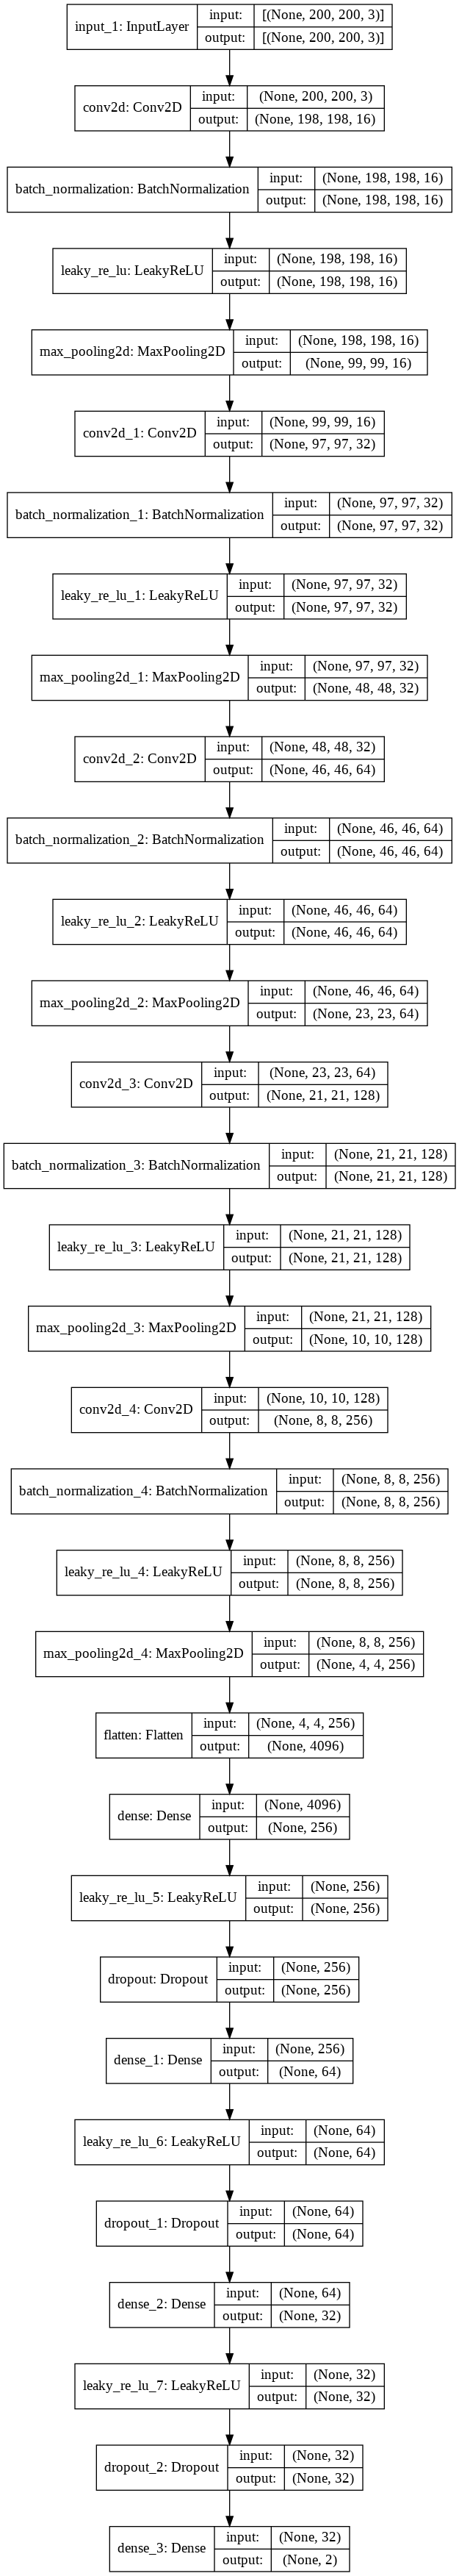

In [ ]:
tf.keras.utils.plot_model( model_gender , to_file='architecture.png',show_shapes=True )

In [ ]:
#Run this cell to visualize the training of the model in TensorBoard ( in this notebook itself ).
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/

# Compiling Model

In [ ]:
!pwd

/content


In [ ]:
#dir_loc = '/content/drive/MyDrive/cnn-test-1'
#print(os.path.join(dir_loc, "tb_logs" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S") )) 

/content/drive/MyDrive/cnn-test-1/tb_logs/20210817-094243


In [ ]:
learning_rate = 0.0001
num_epochs = 10
batch_size = 128

train_ds = train_ds.batch( batch_size ).repeat( num_epochs )
test_ds = test_ds.batch( batch_size ).repeat( num_epochs )

In [ ]:
save_dir = '/content/drive/MyDrive/out/new_gender_model.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_dir,verbose=1) #Checkpoint after every epoch

dir_loc = '/content/drive/MyDrive/out'
logdir = os.path.join(dir_loc, "tb-logs" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S") ) #tensorboard logs save location
tensorboard_callback = tf.keras.callbacks.TensorBoard( logdir )

early_stopping_callback = tf.keras.callbacks.EarlyStopping( monitor='val_accuracy' , patience=3 )

model_gender.compile( 
    loss=tf.keras.losses.sparse_categorical_crossentropy , 
    optimizer = tf.keras.optimizers.Adam( learning_rate ) , 
    metrics =[ 'accuracy' ]
)

In [ ]:
model_gender.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 198, 198, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 198, 198, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 97, 32)        128   

# Train Model

In [ ]:
model_gender.fit( 
    train_ds, 
    epochs=num_epochs,  
    validation_data=test_ds, 
    verbose = 1,
    callbacks=[ checkpoint_callback , tensorboard_callback , early_stopping_callback ],
)

Epoch 1/10
1100/1100 [==============================] - 798s 688ms/step - loss: 14.1218 - accuracy: 0.8159 - val_loss: 2.2713 - val_accuracy: 0.8917

Epoch 00001: saving model to /content/drive/MyDrive/out/new_gender_model.h5
Epoch 2/10
1100/1100 [==============================] - 765s 686ms/step - loss: 1.1707 - accuracy: 0.8875 - val_loss: 0.5577 - val_accuracy: 0.9172

Epoch 00002: saving model to /content/drive/MyDrive/out/new_gender_model.h5
Epoch 3/10
1100/1100 [==============================] - 760s 682ms/step - loss: 0.4441 - accuracy: 0.9111 - val_loss: 0.3195 - val_accuracy: 0.9405

Epoch 00003: saving model to /content/drive/MyDrive/out/new_gender_model.h5
Epoch 4/10
1100/1100 [==============================] - 743s 667ms/step - loss: 0.3248 - accuracy: 0.9321 - val_loss: 0.3377 - val_accuracy: 0.9128

Epoch 00004: saving model to /content/drive/MyDrive/out/new_gender_model.h5
Epoch 5/10
1100/1100 [==============================] - 735s 660ms/step - loss: 0.2774 - accuracy: 

# Tensorboard

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir=logdir

# Load Saved Model

In [ ]:
load_dir = '/content/drive/MyDrive/out/new_gender_model.h5'

In [ ]:
model_gender_loaded = tf.keras.models.load_model( load_dir )

In [ ]:
model_gender_loaded.summary()

## Create separate arrays of testing images and their labels

In [ ]:
test_images = []
test_labels = []

In [ ]:
test_ds = test_ds.unbatch()
test_alt_ds = test_ds.take(25)

In [ ]:
sample_dataset.element_spec

(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [ ]:
for image , label in sample_dataset.as_numpy_iterator():
    #print(type(image))
    test_images.append( image )
    test_labels.append( label )

# Converts lists to ndarrays
test_images = np.array( test_images )
test_labels = np.array( test_labels )

In [ ]:
p = model_gender_loaded.evaluate( test_images , test_labels )
print( 'loss is {} \n accuracy is {} %'.format( p[0] , p[1] * 100 ) )

1/1 [==============================] - 0s 72ms/step - loss: 0.9157 - accuracy: 0.6667
loss is 0.9157055020332336 
 accuracy is 66.66666865348816 %


In [ ]:
from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay

# Fetch model predictions for test_x
pred_y = model_gender_loaded.predict( test_images )

In [ ]:
for i in np.argmax( pred_y , axis=1 ):
  print(i)

0
0
0


In [ ]:
for g in test_labels:
  print(g)

0.0
1.0
0.0


In [ ]:
report = classification_report(  test_labels  , np.argmax( pred_y , axis=1 ) , target_names=[ 'male' , 'female' ] )

In [ ]:
print(report)

              precision    recall  f1-score   support

        male       0.67      1.00      0.80         2
      female       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



# Visualize 

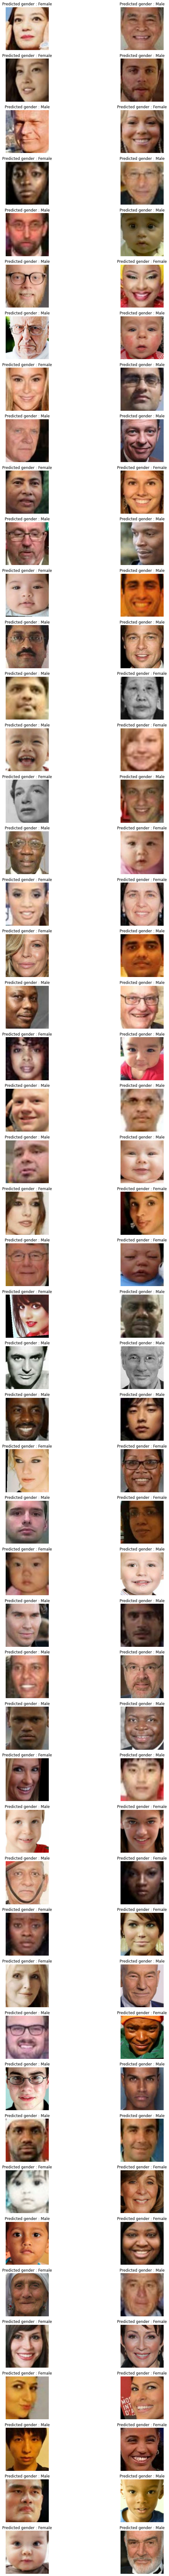

In [ ]:
fig = plt.figure( figsize=( 12 , 150 ) )
classes = [ 'Male' , 'Female' ]
rows = 50
columns = 2

i = 1
for image , label in sample_ds:
    image = image.numpy()
    fig.add_subplot( rows , columns , i )
    plt.imshow( image )
    pred = model_gender_loaded.predict( np.expand_dims( image , 0 ) )
    #print(pred)
    label_ = classes[ np.argmax( pred ) ]
    plt.axis( 'off' )
    plt.title( 'Predicted gender : {}'.format( label_) )
    i += 1